<h1>Zadanie 1</h1>

<h2>CYFROWE PRZETWARZANIE SYGNAŁÓW I OBRAZÓW <br>
Przetwarzanie i analiza sygnału EKG</h2>
<h3>
Kasper Radom 264023 <br>
Maciej Szymczak 263978</h3>

Importowanie niezbędnych bibliotek

In [3]:
%matplotlib ipympl
from matplotlib.widgets import SpanSelector, CheckButtons, Button, TextB,.ox
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display

Funkcja readFile odpowiedzialna jest za wczytywanie danych z pliku

In [4]:
def readFile(filename):
    global ekg
    try:
        with open(filename, 'r') as file:
            ekg = file.read()

    except FileNotFoundError:
        print(f"Plik {filename} nie został znaleziony.")
    except Exception as e:
        print(f"Wystąpił błąd podczas wczytywania pliku {filename}: {e}")


Funkcja callback odpowiada za zarządzanie zdarzeniem po naciśnięcia przycisku (po wybraniu wykresu do wyświetlenia)

In [5]:
def callback(label):
    ln = lines_by_label[label]
    ln.set_visible(not ln.get_visible())
    ln.figure.canvas.draw_idle()

    index = lines.index(ln)
    lines2[index].set_visible(not lines2[index].get_visible())
    lines2[index].figure.canvas.draw_idle()

    onselect(xRange[0], xRange[1])

Funkcja onselect odpowiada za zarządzanie zdarzeniem po zaznaczeniu obszaru na wykresie

In [6]:
def onselect(xmin, xmax):
    global xRange
    xRange = xmin, xmax
    indmin, indmax = np.searchsorted(x, (xmin, xmax))
    indmax = min(len(x) - 1, indmax)

    region_x = x[indmin:indmax]

    if len(region_x) >= 2:
        minY = []
        maxY = []
        for i in range(len(y)):
            region_y = y[i][indmin:indmax]
            lines2[i].set_data(region_x, region_y)
            if lines[i].get_visible():
                maxY.append(max(region_y))
                minY.append(min(region_y))

        if len(minY) != 0:
            axs[1].set_ylim(min(minY), max(maxY))
        axs[1].set_xlim(region_x[0], region_x[-1])
        fig.canvas.draw_idle()

Wybór i wczytanie pliku

In [7]:


options = ['ekg1.txt', 'ekg100.txt', 'ekg_noise.txt']

dropdown = widgets.Dropdown(
    options=options,
    description='Wybierz plik:',
)

output = widgets.interactive_output(readFile, {'filename': dropdown})
display(dropdown, output)



Dropdown(description='Wybierz plik:', options=('ekg1.txt', 'ekg100.txt', 'ekg_noise.txt'), value='ekg1.txt')

Output()

Zgodnie ze znanymi specyfikacjami pliku porządkujemy dane i przypisujemy je do odpowiednich osi w układzie współżędnych

In [8]:
signals = np.array([list(map(float, line.split())) for line in ekg.split("\n")])
#y = ekg.T
y=[[]]
if dropdown.value == "ekg_noise.txt":
    x = signals.T[0]
    y[0] = signals.T[1]
else:
    if dropdown.value == "ekg100.txt":
        f = 360
    else:
        f = 1000
    x = np.arange(1, len(signals) + 1) / f
    y = signals.T

Ustawianie parametrów pierwszego wykresu. Zmienna lines przechowuje wykresy kolejnych sygnałów ekg, natomiast zmienna colors, kolory w celu estetyczniejszej prezentacji danych.

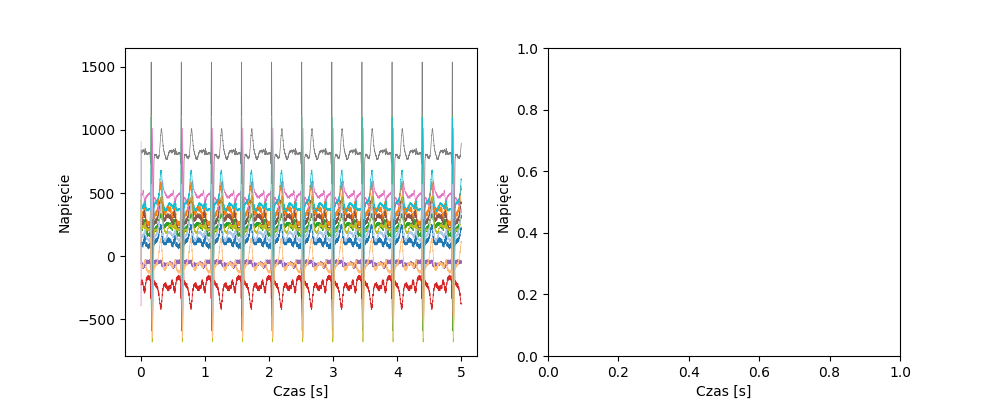

In [9]:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_xlabel('Czas [s]')
axs[0].set_ylabel('Napięcie')
axs[1].set_xlabel('Czas [s]')
axs[1].set_ylabel('Napięcie')
lines=[]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']
colors = colors[:len(y)]
for i in range(len(y)):
        j, = axs[0].plot(x, y[i], visible=True, lw=0.5, color=colors[i], label="ekg "+str(i + 1))
        lines.append(j)

lines_by_label = {l.get_label(): l for l in lines}

Określanie parametrów przycisków wyboru

In [10]:
rax = axs[1].inset_axes([1.0, 0.0, 0.19, 0.8])
check = CheckButtons(
    ax=rax,
    labels=lines_by_label.keys(),
    actives=[l.get_visible() for l in lines_by_label.values()],
    label_props={'color': colors},
    frame_props={'edgecolor': colors},
    check_props={'facecolor': colors},
)

check.on_clicked(callback)

0

Definiowanie drugiego wykresu pomocniczego orzaz zmiennej zapobiegającej później błędom przy wybieraniu kolejnych wykresów

In [11]:

lines2 = []

for _ in range(len(y)):
    line, = axs[1].plot([], [], visible=True, lw=0.5)
    #line.set_visible(False)
    lines2.append(line)

xRange = [0,0]

Określanie parametrów pola umożliwiającego zaznaczenie fragmentu wykresu i prezentacja wykresów

In [12]:
span = SpanSelector(
    axs[0],
    onselect,
    "horizontal",
    useblit=True,
    props=dict(alpha=0.5, facecolor="tab:blue"),
    interactive=True,
    drag_from_anywhere=True
)


Zapisywanie wycinka wykresu do pliku o podanej nazwie

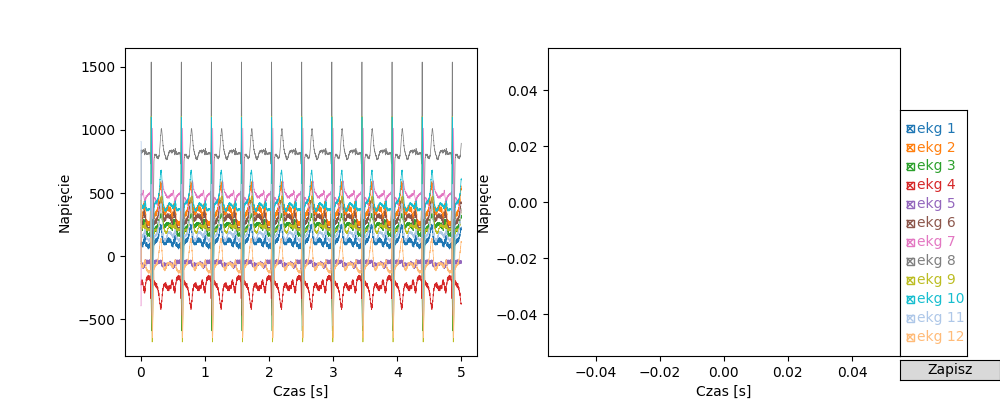

In [13]:
newFileName = "NowyPlik.png"
def savePlot(event):
    global newFileName
    if newFileName.find(".png")==-1 and newFileName.find(".pdf")==-1:
        newFileName+=".png"
    extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(newFileName, bbox_inches=extent.expanded(1.4, 1.2))


save_button_ax = plt.axes([0.9, 0.05, 0.1, 0.05])  # Położenie i rozmiar przycisku
save_button = Button(save_button_ax, 'Zapisz')
save_button.on_clicked(savePlot)  # Przypisanie funkcji do przycisku


plt.show()

In [14]:

# Funkcja wywoływana po zmianie tekstu w polu tekstowym
def update_text(value):
    global newFileName
    newFileName = value

# Tworzenie interaktywnego pola tekstowego
text_widget = widgets.Text(value='NowyPlik.png', description='Nazwa pliku: ')
text_output = widgets.interactive_output(update_text, {'value': text_widget})

# Wyświetlenie pola tekstowego i wykresu
display(text_widget, text_output)


Text(value='NowyPlik.png', description='Nazwa pliku: ')

Output()